# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

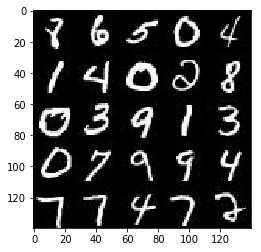

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


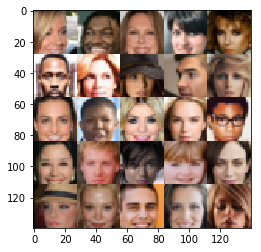

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


/Users/keno/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Flatten the output from the convolutional layers 
    orig_shape = images.get_shape().as_list()
    images = tf.reshape(images, shape=[-1, orig_shape[1] * orig_shape[2] * orig_shape[3]])
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(images, 128, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(0.01 * h1, h1) 
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [32]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse= not is_train):
        
        # Hidden layer
        h1 = tf.layers.dense(z, 128, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(0.01 * h1, h1)
        # Logits and tanh output
        logits = tf.layers.dense(h1, z.get_shape().as_list()[-1], activation=None)
        out = tf.tanh(logits)
        print(out)
        deal_out = tf.reshape(out,(-1,28,28,out_channel_dim))
        
        return deal_out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tensor("Tanh:0", shape=(?, 100), dtype=float32)
Tensor("Tanh_1:0", shape=(?, 100), dtype=float32)
Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tensor("generator/Tanh:0", shape=(?, 4), dtype=float32)
Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    
    print(input_z)
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})
    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [33]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #print(data_shape)

    #sample_z = np.random.uniform(-1, 1, size=(data_shape[-2], z_dim))
    losses = []
    steps = 0
    
    input_real, input_z,learning_rate_1 = model_inputs(data_shape[-3],data_shape[-2],data_shape[-1], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1]) 
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                #print(batch_images.shape)
                # Get images, reshape and rescale to pass to D
                #batch_images = batch_images.reshape((batch_size, 784))
                #batch_images = batch_images*2 - 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print(batch_z.shape)
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 1, input_z, 1, data_image_mode)
                #if steps % 10 == 0:
                #    print(input_z)
                #    show_generator_output(sess, 784, input_z, data_shape[-1], data_image_mode)
        saver.save(sess, './generator.ckpt')
    

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Tensor("generator/Tanh:0", shape=(?, 784), dtype=float32)
Epoch 0/10... Discriminator Loss: 1.3807... Generator Loss: 0.7116
Epoch 0/10... Discriminator Loss: 1.4387... Generator Loss: 0.6204
Epoch 0/10... Discriminator Loss: 1.4098... Generator Loss: 0.6960
Epoch 0/10... Discriminator Loss: 1.4386... Generator Loss: 0.5709
Epoch 0/10... Discriminator Loss: 1.3744... Generator Loss: 0.6937
Epoch 0/10... Discriminator Loss: 1.3806... Generator Loss: 0.6898
Epoch 0/10... Discriminator Loss: 1.3699... Generator Loss: 0.7350
Epoch 0/10... Discriminator Loss: 1.4019... Generator Loss: 0.7429
Epoch 0/10... Discriminator Loss: 1.4597... Generator Loss: 0.6812
Epoch 0/10... Discriminator Loss: 80.4215... Generator Loss: 1183.4548
784
Tensor("generator_1/Tanh:0", shape=(?, 784), dtype=float32)


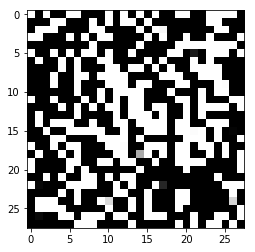

Epoch 0/10... Discriminator Loss: 0.4837... Generator Loss: 19.3083
Epoch 0/10... Discriminator Loss: 0.0000... Generator Loss: 63.6682
Epoch 0/10... Discriminator Loss: 3.6726... Generator Loss: 46.0695
Epoch 0/10... Discriminator Loss: 0.0960... Generator Loss: 24.9116
Epoch 0/10... Discriminator Loss: 0.1120... Generator Loss: 17.4488
Epoch 0/10... Discriminator Loss: 0.0227... Generator Loss: 21.4317
Epoch 0/10... Discriminator Loss: 15.4226... Generator Loss: 90.4633
Epoch 0/10... Discriminator Loss: 0.0437... Generator Loss: 11.8677
Epoch 0/10... Discriminator Loss: 0.9624... Generator Loss: 9.2451
Epoch 0/10... Discriminator Loss: 0.0424... Generator Loss: 6.4770
784
Tensor("generator_2/Tanh:0", shape=(?, 784), dtype=float32)


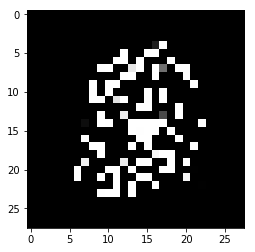

Epoch 0/10... Discriminator Loss: 6.6060... Generator Loss: 0.0024
Epoch 0/10... Discriminator Loss: 0.0654... Generator Loss: 4.5585
Epoch 0/10... Discriminator Loss: 0.0686... Generator Loss: 4.5893
Epoch 0/10... Discriminator Loss: 0.0725... Generator Loss: 4.2907
Epoch 0/10... Discriminator Loss: 3.6197... Generator Loss: 28.7601
Epoch 0/10... Discriminator Loss: 0.0676... Generator Loss: 4.2233
Epoch 0/10... Discriminator Loss: 0.1281... Generator Loss: 3.6515
Epoch 0/10... Discriminator Loss: 0.0611... Generator Loss: 4.5031
Epoch 0/10... Discriminator Loss: 0.1289... Generator Loss: 3.5570
Epoch 0/10... Discriminator Loss: 0.1637... Generator Loss: 6.0299
784
Tensor("generator_3/Tanh:0", shape=(?, 784), dtype=float32)


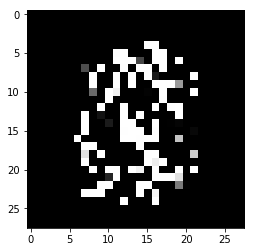

Epoch 1/10... Discriminator Loss: 0.1490... Generator Loss: 4.9784
Epoch 1/10... Discriminator Loss: 0.0770... Generator Loss: 4.0297
Epoch 1/10... Discriminator Loss: 0.1854... Generator Loss: 4.7469
Epoch 1/10... Discriminator Loss: 2.0031... Generator Loss: 17.7783
Epoch 1/10... Discriminator Loss: 1.0236... Generator Loss: 11.4049
Epoch 1/10... Discriminator Loss: 1.4109... Generator Loss: 12.6805
Epoch 1/10... Discriminator Loss: 0.8591... Generator Loss: 10.8331
Epoch 1/10... Discriminator Loss: 0.3225... Generator Loss: 2.4648
Epoch 1/10... Discriminator Loss: 0.4772... Generator Loss: 1.9700
Epoch 1/10... Discriminator Loss: 0.3890... Generator Loss: 1.6938
784
Tensor("generator_4/Tanh:0", shape=(?, 784), dtype=float32)


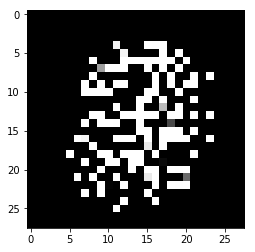

Epoch 1/10... Discriminator Loss: 0.4361... Generator Loss: 1.5580
Epoch 1/10... Discriminator Loss: 8.3569... Generator Loss: 0.0003
Epoch 1/10... Discriminator Loss: 13.9282... Generator Loss: 58.4728
Epoch 1/10... Discriminator Loss: 0.4478... Generator Loss: 3.2947
Epoch 1/10... Discriminator Loss: 2.2482... Generator Loss: 15.2990
Epoch 1/10... Discriminator Loss: 1.3295... Generator Loss: 1.0369
Epoch 1/10... Discriminator Loss: 0.1010... Generator Loss: 5.6140
Epoch 1/10... Discriminator Loss: 0.0889... Generator Loss: 3.3832
Epoch 1/10... Discriminator Loss: 0.0737... Generator Loss: 7.3104
Epoch 1/10... Discriminator Loss: 0.0732... Generator Loss: 13.2135
784
Tensor("generator_5/Tanh:0", shape=(?, 784), dtype=float32)


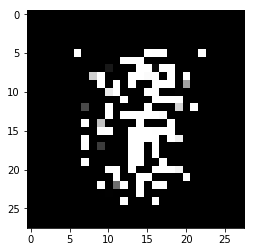

Epoch 1/10... Discriminator Loss: 0.0717... Generator Loss: 4.4211
Epoch 1/10... Discriminator Loss: 0.1897... Generator Loss: 2.6750
Epoch 1/10... Discriminator Loss: 0.1155... Generator Loss: 4.1900
Epoch 1/10... Discriminator Loss: 0.1330... Generator Loss: 3.6778
Epoch 1/10... Discriminator Loss: 0.1216... Generator Loss: 3.6688
Epoch 1/10... Discriminator Loss: 15.5032... Generator Loss: 63.9520
Epoch 1/10... Discriminator Loss: 0.1205... Generator Loss: 6.0803
Epoch 1/10... Discriminator Loss: 0.1231... Generator Loss: 3.8626
Epoch 1/10... Discriminator Loss: 0.1990... Generator Loss: 2.8468
Epoch 1/10... Discriminator Loss: 0.2704... Generator Loss: 5.2653
784
Tensor("generator_6/Tanh:0", shape=(?, 784), dtype=float32)


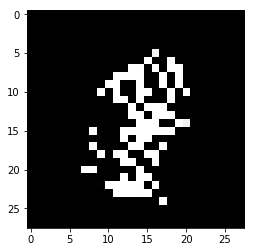

Epoch 2/10... Discriminator Loss: 0.2847... Generator Loss: 2.6255
Epoch 2/10... Discriminator Loss: 0.5284... Generator Loss: 5.1027
Epoch 2/10... Discriminator Loss: 0.8220... Generator Loss: 6.6448
Epoch 2/10... Discriminator Loss: 0.4693... Generator Loss: 1.7478
Epoch 2/10... Discriminator Loss: 0.3453... Generator Loss: 2.4029
Epoch 2/10... Discriminator Loss: 0.3648... Generator Loss: 2.3272
Epoch 2/10... Discriminator Loss: 0.6895... Generator Loss: 1.2996
Epoch 2/10... Discriminator Loss: 0.4012... Generator Loss: 1.4769
Epoch 2/10... Discriminator Loss: 0.6131... Generator Loss: 5.3899
Epoch 2/10... Discriminator Loss: 0.3050... Generator Loss: 2.4558
784
Tensor("generator_7/Tanh:0", shape=(?, 784), dtype=float32)


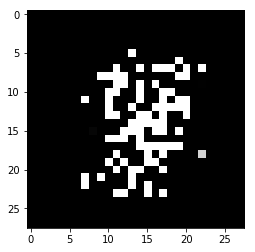

Epoch 2/10... Discriminator Loss: 0.2453... Generator Loss: 2.6610
Epoch 2/10... Discriminator Loss: 0.1809... Generator Loss: 2.8852
Epoch 2/10... Discriminator Loss: 0.2473... Generator Loss: 2.5807
Epoch 2/10... Discriminator Loss: 0.1907... Generator Loss: 2.6425
Epoch 2/10... Discriminator Loss: 0.3073... Generator Loss: 2.4967
Epoch 2/10... Discriminator Loss: 0.2289... Generator Loss: 2.6206
Epoch 2/10... Discriminator Loss: 0.2147... Generator Loss: 2.9015
Epoch 2/10... Discriminator Loss: 0.1593... Generator Loss: 3.3976
Epoch 2/10... Discriminator Loss: 0.3799... Generator Loss: 2.3236
Epoch 2/10... Discriminator Loss: 0.3249... Generator Loss: 2.4511
784
Tensor("generator_8/Tanh:0", shape=(?, 784), dtype=float32)


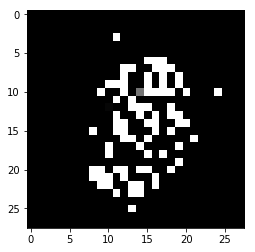

Epoch 2/10... Discriminator Loss: 0.3000... Generator Loss: 2.4766
Epoch 2/10... Discriminator Loss: 0.3310... Generator Loss: 2.6400
Epoch 2/10... Discriminator Loss: 0.4253... Generator Loss: 2.2004
Epoch 2/10... Discriminator Loss: 0.0520... Generator Loss: 3.2439
Epoch 2/10... Discriminator Loss: 1.3364... Generator Loss: 7.7655
Epoch 2/10... Discriminator Loss: 0.3479... Generator Loss: 2.4299
Epoch 2/10... Discriminator Loss: 0.3185... Generator Loss: 2.3578
Epoch 2/10... Discriminator Loss: 0.3237... Generator Loss: 2.3993
Epoch 2/10... Discriminator Loss: 0.2971... Generator Loss: 2.4724
Epoch 2/10... Discriminator Loss: 0.3198... Generator Loss: 2.3007
784
Tensor("generator_9/Tanh:0", shape=(?, 784), dtype=float32)


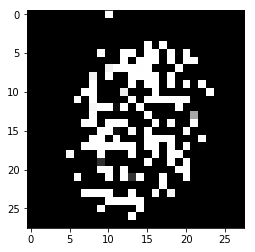

Epoch 3/10... Discriminator Loss: 0.3004... Generator Loss: 2.3923
Epoch 3/10... Discriminator Loss: 0.1481... Generator Loss: 5.0755
Epoch 3/10... Discriminator Loss: 0.2265... Generator Loss: 4.2145
Epoch 3/10... Discriminator Loss: 0.1177... Generator Loss: 4.9145
Epoch 3/10... Discriminator Loss: 0.2033... Generator Loss: 3.7452
Epoch 3/10... Discriminator Loss: 0.2370... Generator Loss: 3.2672
Epoch 3/10... Discriminator Loss: 0.3181... Generator Loss: 2.5025
Epoch 3/10... Discriminator Loss: 0.3091... Generator Loss: 2.8241
Epoch 3/10... Discriminator Loss: 1.9345... Generator Loss: 21.3474
Epoch 3/10... Discriminator Loss: 0.2377... Generator Loss: 2.6189
784
Tensor("generator_10/Tanh:0", shape=(?, 784), dtype=float32)


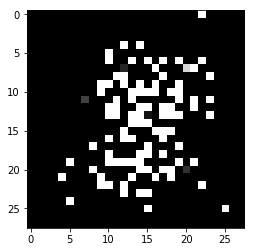

Epoch 3/10... Discriminator Loss: 0.2408... Generator Loss: 2.6082
Epoch 3/10... Discriminator Loss: 0.2546... Generator Loss: 2.5815
Epoch 3/10... Discriminator Loss: 0.2402... Generator Loss: 2.6566
Epoch 3/10... Discriminator Loss: 0.2533... Generator Loss: 3.9513
Epoch 3/10... Discriminator Loss: 0.2061... Generator Loss: 2.8972
Epoch 3/10... Discriminator Loss: 0.2381... Generator Loss: 5.5465
Epoch 3/10... Discriminator Loss: 0.2627... Generator Loss: 3.6781
Epoch 3/10... Discriminator Loss: 0.1506... Generator Loss: 3.3804
Epoch 3/10... Discriminator Loss: 0.1142... Generator Loss: 4.5520
Epoch 3/10... Discriminator Loss: 2.4790... Generator Loss: 18.9518
784
Tensor("generator_11/Tanh:0", shape=(?, 784), dtype=float32)


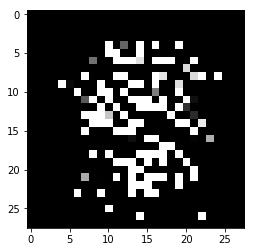

Epoch 3/10... Discriminator Loss: 0.0946... Generator Loss: 3.6889
Epoch 3/10... Discriminator Loss: 0.0987... Generator Loss: 3.1546
Epoch 3/10... Discriminator Loss: 0.1552... Generator Loss: 3.1335
Epoch 3/10... Discriminator Loss: 0.1685... Generator Loss: 2.9113
Epoch 3/10... Discriminator Loss: 0.1672... Generator Loss: 3.0709
Epoch 3/10... Discriminator Loss: 0.1522... Generator Loss: 3.2396
Epoch 3/10... Discriminator Loss: 0.1620... Generator Loss: 3.1986
Epoch 3/10... Discriminator Loss: 0.2204... Generator Loss: 2.8918
Epoch 3/10... Discriminator Loss: 0.2063... Generator Loss: 2.6923
Epoch 3/10... Discriminator Loss: 0.2117... Generator Loss: 2.8362
784
Tensor("generator_12/Tanh:0", shape=(?, 784), dtype=float32)


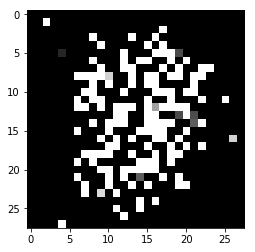

Epoch 4/10... Discriminator Loss: 0.1461... Generator Loss: 3.2105
Epoch 4/10... Discriminator Loss: 0.2852... Generator Loss: 1.8212
Epoch 4/10... Discriminator Loss: 0.0925... Generator Loss: 3.6524
Epoch 4/10... Discriminator Loss: 0.1164... Generator Loss: 3.6396
Epoch 4/10... Discriminator Loss: 0.1236... Generator Loss: 3.6239
Epoch 4/10... Discriminator Loss: 0.1716... Generator Loss: 3.2150
Epoch 4/10... Discriminator Loss: 0.1469... Generator Loss: 3.2481
Epoch 4/10... Discriminator Loss: 0.1246... Generator Loss: 3.4946
Epoch 4/10... Discriminator Loss: 0.1509... Generator Loss: 3.5764
Epoch 4/10... Discriminator Loss: 0.1208... Generator Loss: 4.1449
784
Tensor("generator_13/Tanh:0", shape=(?, 784), dtype=float32)


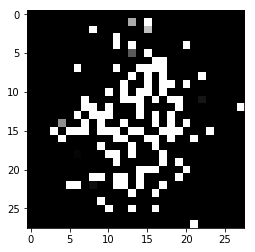

Epoch 4/10... Discriminator Loss: 0.1275... Generator Loss: 3.3490
Epoch 4/10... Discriminator Loss: 1.2802... Generator Loss: 4.4510
Epoch 4/10... Discriminator Loss: 0.2094... Generator Loss: 2.4008
Epoch 4/10... Discriminator Loss: 0.0913... Generator Loss: 4.4044
Epoch 4/10... Discriminator Loss: 0.9305... Generator Loss: 0.6437
Epoch 4/10... Discriminator Loss: 0.0655... Generator Loss: 3.7445
Epoch 4/10... Discriminator Loss: 0.1452... Generator Loss: 2.8747
Epoch 4/10... Discriminator Loss: 0.2300... Generator Loss: 2.2437
Epoch 4/10... Discriminator Loss: 0.0460... Generator Loss: 4.6155
Epoch 4/10... Discriminator Loss: 0.0913... Generator Loss: 3.6399
784
Tensor("generator_14/Tanh:0", shape=(?, 784), dtype=float32)


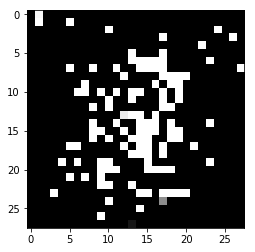

Epoch 4/10... Discriminator Loss: 0.1193... Generator Loss: 3.6921
Epoch 4/10... Discriminator Loss: 0.1471... Generator Loss: 5.7046
Epoch 4/10... Discriminator Loss: 0.0839... Generator Loss: 4.1670
Epoch 4/10... Discriminator Loss: 0.0761... Generator Loss: 4.3916
Epoch 4/10... Discriminator Loss: 0.0751... Generator Loss: 4.3466
Epoch 4/10... Discriminator Loss: 0.0906... Generator Loss: 3.6547
Epoch 4/10... Discriminator Loss: 0.0887... Generator Loss: 3.7155
Epoch 4/10... Discriminator Loss: 0.0838... Generator Loss: 4.0207
Epoch 4/10... Discriminator Loss: 0.0549... Generator Loss: 4.7125
Epoch 4/10... Discriminator Loss: 0.0852... Generator Loss: 3.6716
784
Tensor("generator_15/Tanh:0", shape=(?, 784), dtype=float32)


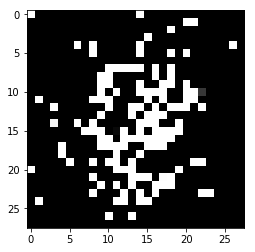

Epoch 5/10... Discriminator Loss: 0.0378... Generator Loss: 5.0254
Epoch 5/10... Discriminator Loss: 0.0298... Generator Loss: 13.5804
Epoch 5/10... Discriminator Loss: 0.0839... Generator Loss: 3.9742
Epoch 5/10... Discriminator Loss: 0.0753... Generator Loss: 4.0056
Epoch 5/10... Discriminator Loss: 0.0777... Generator Loss: 4.0566
Epoch 5/10... Discriminator Loss: 0.0685... Generator Loss: 3.9728
Epoch 5/10... Discriminator Loss: 0.0633... Generator Loss: 4.6389
Epoch 5/10... Discriminator Loss: 0.0651... Generator Loss: 4.3744
Epoch 5/10... Discriminator Loss: 0.0208... Generator Loss: 7.8572
Epoch 5/10... Discriminator Loss: 0.0177... Generator Loss: 6.3467
784
Tensor("generator_16/Tanh:0", shape=(?, 784), dtype=float32)


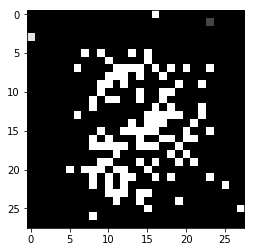

Epoch 5/10... Discriminator Loss: 0.0787... Generator Loss: 6.1925
Epoch 5/10... Discriminator Loss: 0.0145... Generator Loss: 6.3546
Epoch 5/10... Discriminator Loss: 0.6762... Generator Loss: 5.6580
Epoch 5/10... Discriminator Loss: 0.0246... Generator Loss: 5.0910
Epoch 5/10... Discriminator Loss: 0.0667... Generator Loss: 15.0502
Epoch 5/10... Discriminator Loss: 0.1315... Generator Loss: 5.1198
Epoch 5/10... Discriminator Loss: 0.1497... Generator Loss: 3.1160
Epoch 5/10... Discriminator Loss: 0.1604... Generator Loss: 3.3885
Epoch 5/10... Discriminator Loss: 0.1115... Generator Loss: 4.0016
Epoch 5/10... Discriminator Loss: 0.1485... Generator Loss: 3.1870
784
Tensor("generator_17/Tanh:0", shape=(?, 784), dtype=float32)


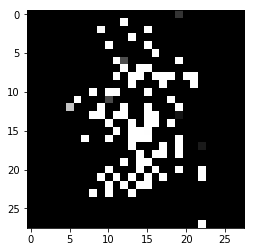

Epoch 5/10... Discriminator Loss: 0.1417... Generator Loss: 2.9250
Epoch 5/10... Discriminator Loss: 0.1184... Generator Loss: 2.9888
Epoch 5/10... Discriminator Loss: 0.1382... Generator Loss: 2.7350
Epoch 5/10... Discriminator Loss: 0.1069... Generator Loss: 3.3177
Epoch 5/10... Discriminator Loss: 0.0824... Generator Loss: 3.8463
Epoch 5/10... Discriminator Loss: 0.2672... Generator Loss: 1.6504
Epoch 5/10... Discriminator Loss: 0.0920... Generator Loss: 3.7475
Epoch 5/10... Discriminator Loss: 0.0900... Generator Loss: 3.9608
Epoch 5/10... Discriminator Loss: 0.0689... Generator Loss: 4.0006
Epoch 5/10... Discriminator Loss: 0.0828... Generator Loss: 3.7395
784
Tensor("generator_18/Tanh:0", shape=(?, 784), dtype=float32)


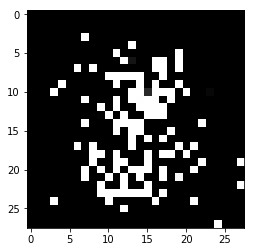

Epoch 6/10... Discriminator Loss: 0.0609... Generator Loss: 4.8419
Epoch 6/10... Discriminator Loss: 0.0620... Generator Loss: 4.6334
Epoch 6/10... Discriminator Loss: 0.0391... Generator Loss: 5.0017
Epoch 6/10... Discriminator Loss: 0.0386... Generator Loss: 5.1026
Epoch 6/10... Discriminator Loss: 0.0434... Generator Loss: 4.5216
Epoch 6/10... Discriminator Loss: 0.0413... Generator Loss: 4.4037
Epoch 6/10... Discriminator Loss: 0.0430... Generator Loss: 4.3036
Epoch 6/10... Discriminator Loss: 0.0446... Generator Loss: 4.2657
Epoch 6/10... Discriminator Loss: 0.0742... Generator Loss: 3.3551
Epoch 6/10... Discriminator Loss: 0.0524... Generator Loss: 4.3473
784
Tensor("generator_19/Tanh:0", shape=(?, 784), dtype=float32)


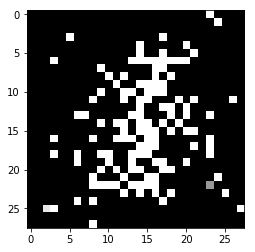

Epoch 6/10... Discriminator Loss: 0.0496... Generator Loss: 4.1789
Epoch 6/10... Discriminator Loss: 0.0365... Generator Loss: 4.7712
Epoch 6/10... Discriminator Loss: 0.0329... Generator Loss: 5.0438
Epoch 6/10... Discriminator Loss: 0.0388... Generator Loss: 5.0343
Epoch 6/10... Discriminator Loss: 0.0296... Generator Loss: 4.9716
Epoch 6/10... Discriminator Loss: 0.1292... Generator Loss: 10.9420
Epoch 6/10... Discriminator Loss: 0.0451... Generator Loss: 7.2291
Epoch 6/10... Discriminator Loss: 0.0861... Generator Loss: 12.9990
Epoch 6/10... Discriminator Loss: 0.0256... Generator Loss: 5.8944
Epoch 6/10... Discriminator Loss: 0.0293... Generator Loss: 5.1462
784
Tensor("generator_20/Tanh:0", shape=(?, 784), dtype=float32)


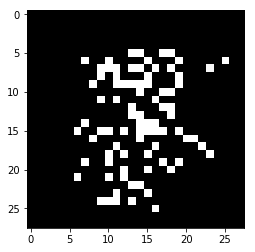

Epoch 6/10... Discriminator Loss: 0.0239... Generator Loss: 5.2676
Epoch 6/10... Discriminator Loss: 0.0281... Generator Loss: 4.9473
Epoch 6/10... Discriminator Loss: 0.0310... Generator Loss: 4.8861
Epoch 6/10... Discriminator Loss: 0.0247... Generator Loss: 5.1351
Epoch 6/10... Discriminator Loss: 0.0273... Generator Loss: 5.2476
Epoch 6/10... Discriminator Loss: 0.0423... Generator Loss: 5.1461
Epoch 6/10... Discriminator Loss: 0.0293... Generator Loss: 5.0418
Epoch 6/10... Discriminator Loss: 0.0267... Generator Loss: 5.0902
Epoch 6/10... Discriminator Loss: 0.0259... Generator Loss: 5.2399
Epoch 6/10... Discriminator Loss: 0.0416... Generator Loss: 4.9516
784
Tensor("generator_21/Tanh:0", shape=(?, 784), dtype=float32)


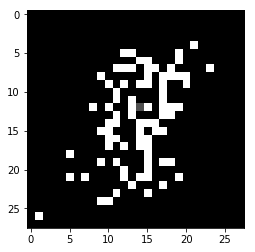

Epoch 7/10... Discriminator Loss: 0.0340... Generator Loss: 4.9701
Epoch 7/10... Discriminator Loss: 0.0274... Generator Loss: 5.2905
Epoch 7/10... Discriminator Loss: 0.0315... Generator Loss: 4.8327
Epoch 7/10... Discriminator Loss: 0.0339... Generator Loss: 5.5545
Epoch 7/10... Discriminator Loss: 0.0395... Generator Loss: 5.8230
Epoch 7/10... Discriminator Loss: 0.0285... Generator Loss: 4.9804
Epoch 7/10... Discriminator Loss: 0.0371... Generator Loss: 6.6701
Epoch 7/10... Discriminator Loss: 0.0381... Generator Loss: 5.5372
Epoch 7/10... Discriminator Loss: 0.0420... Generator Loss: 5.7241
Epoch 7/10... Discriminator Loss: 0.0264... Generator Loss: 7.3716
784
Tensor("generator_22/Tanh:0", shape=(?, 784), dtype=float32)


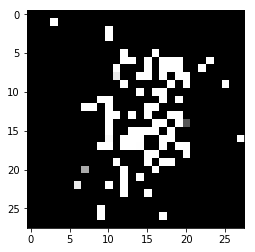

Epoch 7/10... Discriminator Loss: 0.0454... Generator Loss: 7.2012
Epoch 7/10... Discriminator Loss: 0.0407... Generator Loss: 6.9441
Epoch 7/10... Discriminator Loss: 0.0427... Generator Loss: 5.6247
Epoch 7/10... Discriminator Loss: 0.0391... Generator Loss: 6.1050
Epoch 7/10... Discriminator Loss: 0.0342... Generator Loss: 6.8963
Epoch 7/10... Discriminator Loss: 0.0330... Generator Loss: 4.6623
Epoch 7/10... Discriminator Loss: 0.0216... Generator Loss: 5.7303
Epoch 7/10... Discriminator Loss: 0.0451... Generator Loss: 6.6151
Epoch 7/10... Discriminator Loss: 0.0330... Generator Loss: 7.6594
Epoch 7/10... Discriminator Loss: 0.0215... Generator Loss: 4.9314
784
Tensor("generator_23/Tanh:0", shape=(?, 784), dtype=float32)


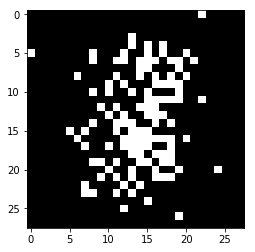

Epoch 7/10... Discriminator Loss: 0.0646... Generator Loss: 3.5560
Epoch 7/10... Discriminator Loss: 0.0471... Generator Loss: 6.3857
Epoch 7/10... Discriminator Loss: 0.0219... Generator Loss: 6.6527
Epoch 7/10... Discriminator Loss: 0.0137... Generator Loss: 6.8602
Epoch 7/10... Discriminator Loss: 0.0107... Generator Loss: 7.3786
Epoch 7/10... Discriminator Loss: 0.0083... Generator Loss: 7.3933
Epoch 7/10... Discriminator Loss: 0.0072... Generator Loss: 7.6340
Epoch 7/10... Discriminator Loss: 0.0063... Generator Loss: 7.4881
Epoch 7/10... Discriminator Loss: 0.0053... Generator Loss: 8.0050
Epoch 7/10... Discriminator Loss: 0.0054... Generator Loss: 7.0913
784
Tensor("generator_24/Tanh:0", shape=(?, 784), dtype=float32)


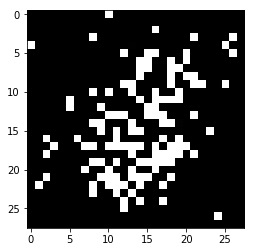

Epoch 8/10... Discriminator Loss: 0.0044... Generator Loss: 8.0865
Epoch 8/10... Discriminator Loss: 0.0040... Generator Loss: 8.6177
Epoch 8/10... Discriminator Loss: 0.0156... Generator Loss: 8.5985
Epoch 8/10... Discriminator Loss: 0.0033... Generator Loss: 8.7161
Epoch 8/10... Discriminator Loss: 0.0032... Generator Loss: 8.6136
Epoch 8/10... Discriminator Loss: 0.0030... Generator Loss: 8.6465
Epoch 8/10... Discriminator Loss: 0.0027... Generator Loss: 8.6027
Epoch 8/10... Discriminator Loss: 0.0031... Generator Loss: 7.8305
Epoch 8/10... Discriminator Loss: 0.1725... Generator Loss: 2.9682
Epoch 8/10... Discriminator Loss: 0.0504... Generator Loss: 4.7545
784
Tensor("generator_25/Tanh:0", shape=(?, 784), dtype=float32)


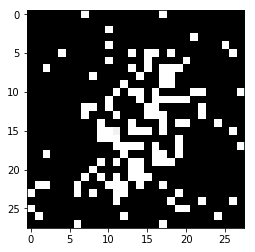

Epoch 8/10... Discriminator Loss: 0.0337... Generator Loss: 5.1005
Epoch 8/10... Discriminator Loss: 0.0268... Generator Loss: 5.2832
Epoch 8/10... Discriminator Loss: 0.0263... Generator Loss: 5.4939
Epoch 8/10... Discriminator Loss: 0.0321... Generator Loss: 5.6258
Epoch 8/10... Discriminator Loss: 0.0316... Generator Loss: 4.7469
Epoch 8/10... Discriminator Loss: 0.0237... Generator Loss: 5.5720
Epoch 8/10... Discriminator Loss: 0.0258... Generator Loss: 5.1497
Epoch 8/10... Discriminator Loss: 0.2105... Generator Loss: 2.0000
Epoch 8/10... Discriminator Loss: 0.0432... Generator Loss: 4.9358
Epoch 8/10... Discriminator Loss: 0.0228... Generator Loss: 8.0218
784
Tensor("generator_26/Tanh:0", shape=(?, 784), dtype=float32)


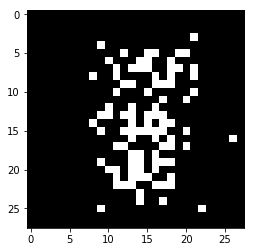

Epoch 8/10... Discriminator Loss: 0.0090... Generator Loss: 6.7036
Epoch 8/10... Discriminator Loss: 0.0028... Generator Loss: 9.0584
Epoch 8/10... Discriminator Loss: 0.0064... Generator Loss: 8.2651
Epoch 8/10... Discriminator Loss: 0.0018... Generator Loss: 7.8806
Epoch 8/10... Discriminator Loss: 0.0017... Generator Loss: 8.2175
Epoch 8/10... Discriminator Loss: 0.0016... Generator Loss: 8.4750
Epoch 8/10... Discriminator Loss: 0.0020... Generator Loss: 7.3169
Epoch 8/10... Discriminator Loss: 0.0175... Generator Loss: 7.6118
Epoch 8/10... Discriminator Loss: 0.0011... Generator Loss: 7.6027
Epoch 8/10... Discriminator Loss: 0.0062... Generator Loss: 6.4219
784
Tensor("generator_27/Tanh:0", shape=(?, 784), dtype=float32)


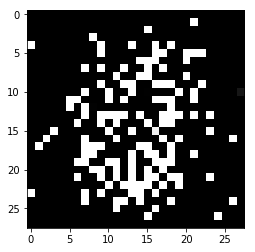

Epoch 9/10... Discriminator Loss: 0.0073... Generator Loss: 5.7382
Epoch 9/10... Discriminator Loss: 0.0158... Generator Loss: 5.4985
Epoch 9/10... Discriminator Loss: 0.0114... Generator Loss: 5.5570
Epoch 9/10... Discriminator Loss: 0.0174... Generator Loss: 5.7063
Epoch 9/10... Discriminator Loss: 0.0159... Generator Loss: 5.5457
Epoch 9/10... Discriminator Loss: 0.0278... Generator Loss: 5.4710
Epoch 9/10... Discriminator Loss: 0.0477... Generator Loss: 5.5567
Epoch 9/10... Discriminator Loss: 0.0548... Generator Loss: 3.8265
Epoch 9/10... Discriminator Loss: 0.2974... Generator Loss: 11.6585
Epoch 9/10... Discriminator Loss: 0.0380... Generator Loss: 4.6942
784
Tensor("generator_28/Tanh:0", shape=(?, 784), dtype=float32)


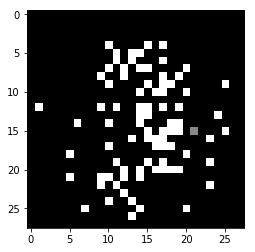

Epoch 9/10... Discriminator Loss: 0.0429... Generator Loss: 5.6089
Epoch 9/10... Discriminator Loss: 0.0497... Generator Loss: 4.1891
Epoch 9/10... Discriminator Loss: 0.0505... Generator Loss: 4.4501
Epoch 9/10... Discriminator Loss: 0.0314... Generator Loss: 4.9475
Epoch 9/10... Discriminator Loss: 0.0364... Generator Loss: 4.8215
Epoch 9/10... Discriminator Loss: 0.0365... Generator Loss: 4.6838
Epoch 9/10... Discriminator Loss: 0.0362... Generator Loss: 4.9749
Epoch 9/10... Discriminator Loss: 0.0291... Generator Loss: 5.0231
Epoch 9/10... Discriminator Loss: 0.0269... Generator Loss: 4.9375
Epoch 9/10... Discriminator Loss: 0.0351... Generator Loss: 4.6806
784
Tensor("generator_29/Tanh:0", shape=(?, 784), dtype=float32)


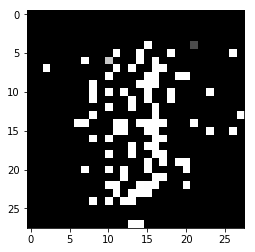

Epoch 9/10... Discriminator Loss: 0.0325... Generator Loss: 4.8809
Epoch 9/10... Discriminator Loss: 0.0287... Generator Loss: 4.9901
Epoch 9/10... Discriminator Loss: 0.0301... Generator Loss: 4.9963
Epoch 9/10... Discriminator Loss: 0.0352... Generator Loss: 4.9782
Epoch 9/10... Discriminator Loss: 0.0324... Generator Loss: 5.1113
Epoch 9/10... Discriminator Loss: 0.0313... Generator Loss: 4.8017
Epoch 9/10... Discriminator Loss: 0.0268... Generator Loss: 4.9119
Epoch 9/10... Discriminator Loss: 0.0232... Generator Loss: 5.0766
Epoch 9/10... Discriminator Loss: 0.0210... Generator Loss: 5.2689
Epoch 9/10... Discriminator Loss: 0.0310... Generator Loss: 4.6636
784
Tensor("generator_30/Tanh:0", shape=(?, 784), dtype=float32)


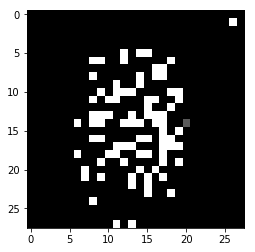

In [34]:
batch_size = 200
z_dim = 784
learning_rate = 0.02
beta1 = 0.005

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。